# Ultramarathon Data Analysis

## Data Cleanup and Preperation

This dataset can be downloaded from kaggle: https://www.kaggle.com/datasets/aiaiaidavid/the-big-dataset-of-ultra-marathon-running/

In [12]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [1]:
races = pd.read_csv('TWO_CENTURIES_OF_UM_RACES.csv', low_memory=False)
races.head()

,Year of event,Event dates,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete club,Athlete country,Athlete year of birth,Athlete gender,Athlete age category,Athlete average speed,Athlete ID
0,2018,06.01.2018,Selva Costera (CHI),50km,22,4:51:39 h,Tnfrc,CHI,1978.0,M,M35,10.286,0
1,2018,06.01.2018,Selva Costera (CHI),50km,22,5:15:45 h,Roberto Echeverría,CHI,1981.0,M,M35,9.501,1
2,2018,06.01.2018,Selva Costera (CHI),50km,22,5:16:44 h,Puro Trail Osorno,CHI,1987.0,M,M23,9.472,2
3,2018,06.01.2018,Selva Costera (CHI),50km,22,5:34:13 h,Columbia,ARG,1976.0,M,M40,8.976,3
4,2018,06.01.2018,Selva Costera (CHI),50km,22,5:54:14 h,Baguales Trail,CHI,1992.0,M,M23,8.469,4


### 1. Rename columns and convert data types

In [2]:
races = races.rename(mapper={
    'Year of event': 'event_year',
    'Event dates': 'event_dates',
    'Event name': 'event_name',
    'Event distance/length': 'event_distance_or_length',
    'Event number of finishers': 'event_num_finishers',
    'Athlete performance': 'athlete_performance',
    'Athlete club': 'athlete_club',
    'Athlete country': 'athlete_country',
    'Athlete year of birth': 'athlete_birth_year',
    'Athlete gender': 'athlete_gender',
    'Athlete age category': 'athlete_age_category',
    'Athlete average speed': 'athlete_avg_speed',
    'Athlete ID': 'athlete_id'
}, axis=1)
races['athlete_birth_year'] = races['athlete_birth_year'].astype('Int64', errors='ignore')
races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7461195 entries, 0 to 7461194
Data columns (total 13 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   event_year                int64 
 1   event_dates               object
 2   event_name                object
 3   event_distance_or_length  object
 4   event_num_finishers       int64 
 5   athlete_performance       object
 6   athlete_club              object
 7   athlete_country           object
 8   athlete_birth_year        Int64 
 9   athlete_gender            object
 10  athlete_age_category      object
 11  athlete_avg_speed         object
 12  athlete_id                int64 
dtypes: Int64(1), int64(3), object(9)
memory usage: 747.1+ MB


### 2. Itentify stage races and clean up distance

In [3]:
races['stage_race'] = races['event_distance_or_length'].str.contains('Etappen')
races['stage_days'] = races['event_distance_or_length'].str.extract(r'(\d+)Etappen').astype('Int64')
stage_pattern = re.compile(r'/\d+Etappen')
races['event_distance_or_length'] = races['event_distance_or_length'].str.replace(pat=stage_pattern,repl='',regex=True)
races['event_distance_or_length'] = races['event_distance_or_length'].str.replace(pat=r'([mM]iles?)',repl='mi',regex=True)
races['event_distance_or_length'] = races['event_distance_or_length'].str.replace(pat=r'[kK][mM]?',repl='km',regex=True)

In [4]:
races['distance_based'] = races['event_distance_or_length'].str.contains(r'(?:mi|km)')
races[races['distance_based'] == True]['event_distance_or_length'].unique()

array(['50km', '63.9km', '50mi', ..., '2925.7mi', '355km', '2906.1mi'],
      shape=(1593,), dtype=object)

### 3. Extract Start and End Dates for multi-day events

In [5]:
def extract_dates(datestring):
    # datestring = row['event_dates']
    matching = re.findall(r'(\d+)',datestring)
    end_date = matching[-3] + '/' + matching[-2] + '/' + matching[-1]
    start_date = matching[0] + '/'
    if len(matching) >= 5:
        start_date += matching[1] + '/'
    else:
        start_date += matching[-2] + '/'
    if len(matching) == 6:
        start_date += matching[2]
    else:
        start_date += matching[-1]
    return start_date+'-'+end_date

event_dates = races['event_dates'].apply(extract_dates)
races[['start_date','end_date']] = event_dates.str.split('-',expand=True)

### 4. Clean up event name and extract country code

In [6]:
races['event_country'] = races['event_name'].str.extract(r'\((\w{3})\)')
races['event_name'] = races['event_name'].str.extract(r'(^.+)\([A-Z]{3}\)$')

In [7]:
races.count()

event_year                  7461195
event_dates                 7461195
event_name                  7459569
event_distance_or_length    7460142
event_num_finishers         7461195
athlete_performance         7461193
athlete_club                4634671
athlete_country             7461192
athlete_birth_year          6873034
athlete_gender              7461188
athlete_age_category        6876257
athlete_avg_speed           7460971
athlete_id                  7461195
stage_race                  7460142
stage_days                    91944
distance_based              7460142
start_date                  7461195
end_date                    7461195
event_country               7459569
dtype: int64

### 5. Pull out US races

In [8]:
us_race_results = races[(races['event_country'] == 'USA') & (races['event_year']>=1975)]
us_races = us_race_results[[
    'event_year',
    'event_dates',
    'event_name',
    'event_distance_or_length',
    'event_num_finishers',
    'stage_race',
    'stage_days',
    'start_date',
    'end_date',
    'event_country',
    'distance_based'
]].drop_duplicates().reset_index().drop('index',axis=1)

## Popularity of Ultramarathons in the US Since 1975

### Popularity year-over-year

In [15]:
us_races_by_year = us_races.groupby('event_year').agg({'event_name':'nunique','event_num_finishers':'sum','distance_based':'sum'}).reset_index()
us_races_by_year

,event_year,event_name,event_num_finishers,distance_based
0,1975,12,443,12
1,1976,16,506,16
2,1977,34,795,32
3,1978,23,600,21
4,1979,35,876,30
5,1980,83,1462,75
6,1981,168,4285,154
7,1982,208,5026,181
8,1983,251,5713,210
9,1984,232,6048,190


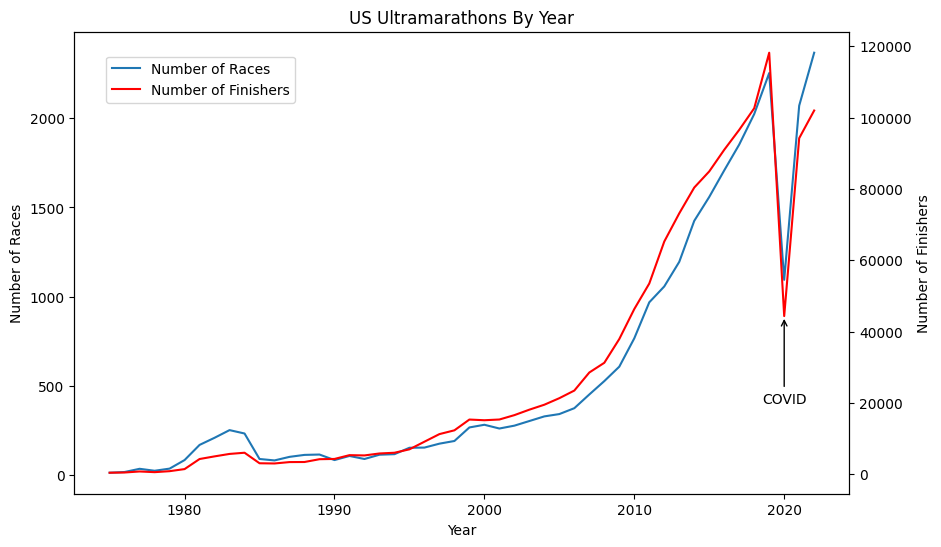

In [138]:
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(us_races_by_year['event_year'],us_races_by_year['event_name'],label='Number of Races')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Races')

ax2 = ax1.twinx()
ax2.plot(us_races_by_year['event_year'],us_races_by_year['event_num_finishers'],color='red',label='Number of Finishers')
ax2.set_ylabel('Number of Finishers')

fig.legend(loc='upper left', bbox_to_anchor=(0.15,.85))

plt.title('US Ultramarathons By Year')

ax2.annotate(
    'COVID',
    xy=(2020,44363),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    xytext=(2020, 20000),
    ha='center'
)
plt.show()

We can see that the popularity of ultramarathons has grown substantially in the US since 1975 with the vast majority of the growth occuring after 2005. 

You might also notice a significant drop in races and participation during COVID. It appears that, while the number of races has returned to pre-COVID levels, the number of participants had not by 2022. 

### What's the most popular race each year?

In [75]:
most_popular_by_year = us_races.loc[us_races.groupby('event_year')['event_num_finishers'].idxmax()][['event_year','event_name','event_num_finishers']]
most_popular_by_year

,event_year,event_name,event_num_finishers
25048,1975,JFK 50 Mile,344
25062,1976,JFK 50 Mile,369
25081,1977,JFK 50 Mile,326
25112,1978,JFK 50 Mile,293
25135,1979,JFK 50 Mile,312
25172,1980,JFK 50 Mile,294
25383,1981,American River 50 Mile Endurance Run,270
25575,1982,American River 50 Mile Endurance Run,324
25823,1983,American River 50 Mile Endurance Run,425
26055,1984,American River 50 Mile Endurance Run,388


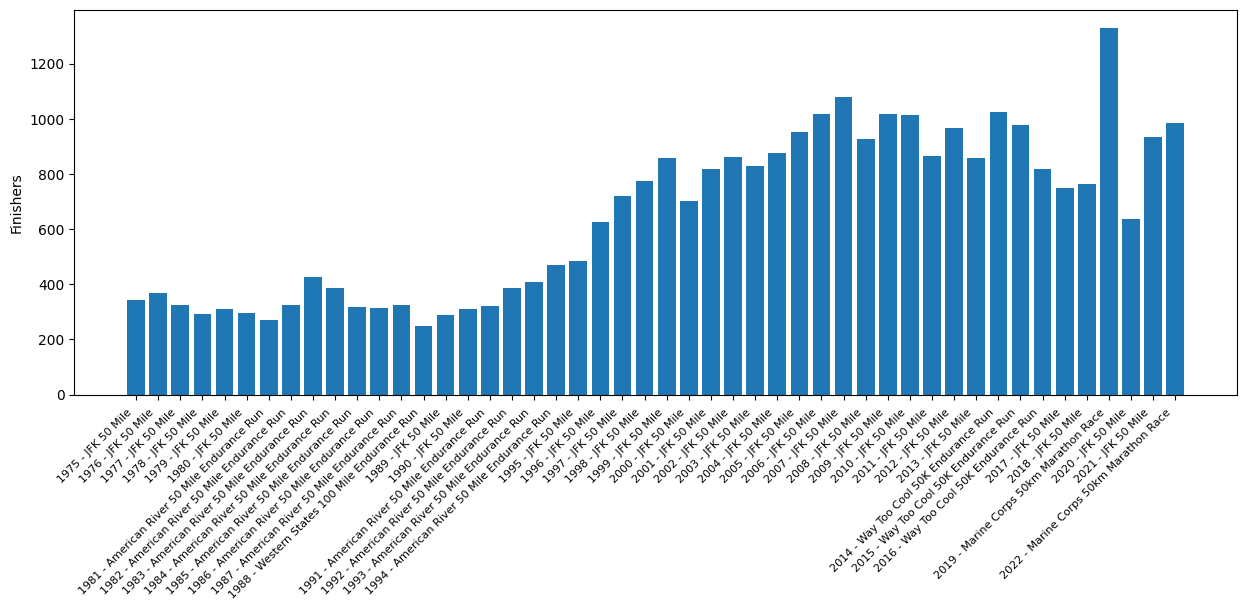

In [140]:
most_popular_by_year['year_name'] = most_popular_by_year['event_year'].astype(str) + ' - ' + most_popular_by_year['event_name']

plt.figure(figsize=(15,5))
plt.bar(most_popular_by_year['year_name'],most_popular_by_year['event_num_finishers'])
plt.xticks(rotation=45,ha='right',fontsize=8)
plt.ylabel('Finishers')
plt.show()

It looks like the **JFK 50 Mile** has dominated as the most popular ultra for more years than any other race since 1975. I was surprised to see that the **Western States 100** was only the most popular race once.

### Which Formats and Distances are Most Popular